In [1]:
from multiprocessing.pool import Pool 
from synthesizer import audio
from functools import partial
from itertools import chain
from pathlib import Path
from utils import logmmse
from tqdm import tqdm
import numpy as np
import librosa

In [2]:
def preprocess_audios(datasets_root, out_dir, n_processes, 
                           skip_existing, hparams, pairs):
    # Gather the input directories
    
    print("\n  Using data from:  " + datasets_root)
    
    # Create the output directories for each output file type
    out_dir.joinpath("mels").mkdir(exist_ok=True)
    out_dir.joinpath("audio").mkdir(exist_ok=True)
    
    # Create a metadata file
    metadata_fpath = out_dir.joinpath("train.txt")
    metadata_file = metadata_fpath.open("a" if skip_existing else "w", encoding="utf-8")

    #print(speaker_dirs)
    func = partial(preprocess_speaker, out_dir=out_dir, skip_existing=skip_existing, 
                   hparams=hparams, datasets_root=datasets_root)
    job = Pool(n_processes).imap(func, pairs)
    for speaker_metadata in tqdm(job, "Proprocess", len(pairs), unit="speakers"):
        print(speaker_metadata)
        for metadatum in speaker_metadata:
            metadata_file.write("|".join(str(x) for x in metadatum) + "\n")
    metadata_file.close()

    # Verify the contents of the metadata file
    with metadata_fpath.open("r", encoding="utf-8") as metadata_file:
        metadata = [line.split("|") for line in metadata_file]
    mel_frames = sum([int(m[4]) for m in metadata])
    timesteps = sum([int(m[3]) for m in metadata])
    sample_rate = hparams.sample_rate
    hours = (timesteps / sample_rate) / 3600
    print("The dataset consists of %d utterances, %d mel frames, %d audio timesteps (%.2f hours)." %
          (len(metadata), mel_frames, timesteps, hours))
    print("Max input length (text chars): %d" % max(len(m[5]) for m in metadata))
    print("Max mel frames length: %d" % max(int(m[4]) for m in metadata))
    print("Max audio timesteps length: %d" % max(int(m[3]) for m in metadata))

In [4]:
def preprocess_speaker(speaker_dir, out_dir: Path, skip_existing: bool, hparams, datasets_root):
    metadata = []
    print(f"Len of speaker dir:{len(speaker_dir)}")
    wav_texts = list( (datasets_root + x[0] + '/' + x[1], x[2]) for x in speaker_dir)
    #wav_texts = [(datasets_root + speaker_dir[0]+'/'+speaker_dir[1],speaker_dir[2])]
    wavs = []
    texts = []
    wav_paths = []
    for wav_path, text in wav_texts:
        wav = split_on_silences(wav_path, hparams)
        wavs.append(wav)
        texts.append(text)
        wav_paths.append(wav_path)
    assert len(wav_paths) == len(wavs) == len(texts)
    for i, (wav, text) in enumerate(zip(wavs, texts)):
            metadata.append(process_utterance(wav, text, out_dir, wav_paths[i].split('/')[-1], 
                                            skip_existing, hparams))
    print(f"metadata:{metadata}")
    return [m for m in metadata if m is not None]



In [5]:
def split_on_silences(wav_fpath, hparams):
    # Load the audio waveform
    #print(f"Wav_path:{wav_fpath}")
    wav, _ = librosa.load(wav_fpath + '.mp3', sr=hparams.sample_rate)
    if hparams.rescale:
        wav = wav / np.abs(wav).max() * hparams.rescaling_max
    
    return wav

In [13]:
def process_utterance(wav, text, out_dir, basename, 
                      skip_existing, hparams):
    ## FOR REFERENCE:
    # For you not to lose your head if you ever wish to change things here or implement your own
    # synthesizer.
    # - Both the audios and the mel spectrograms are saved as numpy arrays
    # - There is no processing done to the audios that will be saved to disk beyond volume  
    #   normalization (in split_on_silences)
    # - However, pre-emphasis is applied to the audios before computing the mel spectrogram. This
    #   is why we re-apply it on the audio on the side of the vocoder.
    # - Librosa pads the waveform before computing the mel spectrogram. Here, the waveform is saved
    #   without extra padding. This means that you won't have an exact relation between the length
    #   of the wav and of the mel spectrogram. See the vocoder data loader.
    
    
    # Skip existing utterances if needed
    print(f"basename:{basename}")
    mel_fpath = out_dir.joinpath("mels", "mel-%s.npy" % basename)
    wav_fpath = out_dir.joinpath("audio", "audio-%s.npy" % basename)
    if skip_existing and mel_fpath.exists() and wav_fpath.exists():
        return None
    
    # Skip utterances that are too short
    if len(wav) < hparams.utterance_min_duration * hparams.sample_rate:
        return None
    
    # Compute the mel spectrogram
    mel_spectrogram = audio.melspectrogram(wav, hparams).astype(np.float32)
    mel_frames = mel_spectrogram.shape[1]
    
    # Skip utterances that are too long
    #if mel_frames > hparams.max_mel_frames and hparams.clip_mels_length:
    #    return None
    
    # Write the spectrogram, embed and audio to disk
    np.save(mel_fpath, mel_spectrogram.T, allow_pickle=False)
    np.save(wav_fpath, wav, allow_pickle=False)
    
    # Return a tuple describing this training example
    return wav_fpath.name, mel_fpath.name, "embed-%s.npy" % basename, len(wav), mel_frames, text

## Preprocess audios parallelly

In [28]:
batch_size=200
pairs = []

# format in metadata.csv
# spk|wav_name|text

with open('processed_mp3_files.csv') as f:
    subpairs = []
    begin = True
    for line in f.readlines():
        #print(line.strip().split('|'))
        subpairs.append(line.strip().split('|'))
        if len(subpairs) % batch_size == 0 and not begin:
            pairs.append(subpairs)
            subpairs = []
            
        begin = False
        
    if len(subpairs) > 0:
        pairs.append(subpairs)
    

['Main String,File Path,Text']
['lamaholot,/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/lamaholot/lamaholot1.mp3,"Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station."']
['fanti,/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/fanti/fanti3.mp3,"Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station."']
['fanti,/home/marinjezidzic/Downloads/t

In [10]:
pairs

[[['lamaholot',
   'lamaholot1',
   'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'],
  ['fanti',
   'fanti3',
   'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'],
  ['fanti',
   'fanti2',
   'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also ne

In [18]:
import re

def separate_numbers_from_string(input_string):
    # Match the pattern for letters before any numbers and file extension
    match = re.match(r'([a-zA-Z]+)\d+\.[a-zA-Z]+', input_string)
    if match:
        main_string = match.group(1)
    else:
        main_string = input_string
    
    return main_string



In [10]:
import os
import re
import shutil

def separate_numbers_from_string(input_string):
    # Match the pattern for letters before any numbers and file extension
    match = re.match(r'([a-zA-Z]+)\d+\.[a-zA-Z]+', input_string)
    if match:
        main_string = match.group(1)
    else:
        main_string = input_string
    
    return main_string

def organize_mp3_files(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mp3'):
            main_string = separate_numbers_from_string(file_name)
            target_folder = os.path.join(folder_path, main_string)
            if not os.path.exists(target_folder):
                os.makedirs(target_folder)
            shutil.move(os.path.join(folder_path, file_name), os.path.join(target_folder, file_name))

# Specify your folder path here
folder_path = '/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset'

# Organize the files
organize_mp3_files(folder_path)


In [18]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 27.6 MB/s eta 0:00:00m eta 0:00:010:0101


Results have been written to processed_mp3_files.csv


In [7]:
import os
import re
string = 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'
def separate_numbers_from_string(input_string):
    # Match the pattern for letters before any numbers and file extension
    match = re.match(r'([a-zA-Z]+)\d+\.[a-zA-Z]+', input_string)
    if match:
        main_string = match.group(1)
    else:
        main_string = input_string
    
    return main_string

def process_mp3_files(folder_path):
    result_list=[]
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.mp3'):
                main_string = separate_numbers_from_string(file_name)
                result_list.append( [main_string, file_name[:-4], string] )
    return result_list

# Specify your folder path here
folder_path = '/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset'

# Get the processed list
processed_list = process_mp3_files(folder_path)

# Print the result
paths=[folder_path+'/'+item[0]+'/'+item[1]+ '.mp3' for item in processed_list]
for item in processed_list:
    path=folder_path+'/'+item[0]+'/'+item[1]+ '.mp3'


/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/lamaholot/lamaholot1.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/fanti/fanti3.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/fanti/fanti2.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/fanti/fanti1.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/swedish/swedish4.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/swedish/swedish3.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/swedish/swedish20.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/swedish/swedish12.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/swedish/swedish15.mp3
/home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/swedish/swedish2.mp3
/home/marinjezidzic/Downloads/tf_mu

In [8]:
batch_size=200
pairs = []

# format in metadata.csv
# spk|wav_name|text


subpairs = []
begin = True
for x in processed_list:
    subpairs.append(x)
    if len(subpairs) % batch_size == 0 and not begin:
        pairs.append(subpairs)
        subpairs = []

    begin = False

if len(subpairs) > 0:
    pairs.append(subpairs)

In [14]:
from synthesizer.hparams import hparams
from pathlib import Path

# rootpath is the path to the wav files

# the path to store features, including audio and mel-spectrogram
outpath = Path("datasets/syn_accent/").joinpath("synthesizer")
outpath.mkdir(exist_ok=True, parents=True)

preprocess_audios(folder_path+'/', outpath, 16, True, hparams, pairs )


  Using data from:  /home/marinjezidzic/Downloads/tf_multispeakerTTS_fc/datasets/accent_dataset/


Proprocess:   0%|                                                                                                | 0/11 [00:00<?, ?speakers/s]

Len of speaker dir:200Len of speaker dir:200Len of speaker dir:200Len of speaker dir:200Len of speaker dir:200Len of speaker dir:200
Len of speaker dir:200
Len of speaker dir:200
Len of speaker dir:200





Len of speaker dir:200
Len of speaker dir:137
basename:macedonian11
basename:macedonian16
basename:macedonian18
basename:bosnian8
basename:bosnian6
basename:bosnian1
basename:bosnian7
basename:bosnian9
basename:bosnian4
basename:bosnian3
basename:bosnian2
basename:bosnian5
basename:ebira1
basename:kalanga1
basename:albanian8
basename:english368
basename:albanian1
basename:english230
basename:english127
basename:albanian6
basename:english546
basename:albanian7
basename:english89
basename:english419
basename:albanian9
basename:english58
basename:albanian3
basename:english237
basename:albanian4
basename:english120
basename:albanian5
basename:english541
basename:albanian2
basename:english465
basename:wu1
basename:english313
basename:english24
basename:kanuri1
basename:english87
basename

basename:indonesian7
basename:spanish131basename:kurdish6basename:dutch13
basename:arabic32


basename:ukrainian1basename:swedish18

basename:mandarin32
basename:english426basename:indonesian3

basename:punjabi6basename:english279
basename:ukrainian10
basename:swedish9basename:arabic98
basename:dutch14


basename:mandarin17basename:spanish33
basename:english381basename:indonesian4

basename:swedish7basename:dutch9basename:arabic49
basename:english573



basename:kurdish1
basename:punjabi1
basename:sardinian1
basename:indonesian5
basename:spanish104basename:english112

basename:dutch7basename:english208basename:punjabi8

basename:mandarin10
basename:arabic35

basename:turkmen1
basename:english205
basename:indonesian2basename:dutch42
basename:kurdish8basename:mizo1

basename:english322basename:mandarin62basename:arabic75


basename:english304

basename:dutch39basename:spanish48

basename:mandinka1
basename:bavarian1basename:english33

basename:punjabi10
basename:sundanese1basename:mandar

basename:italian3basename:english109basename:yoruba1basename:arabic22basename:english272basename:danish4

basename:english435


basename:korean13

basename:amharic5
basename:norwegian3
basename:oromo3
basename:taiwanese2

basename:english392
basename:english415
basename:danish3basename:english568

basename:norwegian6
basename:english85basename:oromo2basename:taiwanese5
basename:italian4
basename:arabic59


basename:amharic2basename:english74

basename:english54
basename:norwegian1
basename:danish7
basename:english343basename:korean30basename:english430


basename:arabic88basename:taiwanese4

basename:english363basename:danish8basename:arabic25
basename:italian33basename:malagasy1


basename:ganda1
basename:english397

basename:danish6
basename:english395basename:ganda2basename:italian22basename:amharic20

basename:english469

basename:korean37
basename:taiwanese3

basename:korean2basename:arabic5
basename:english432basename:papiamentu1


basename:english28
basename:danish1basename:engl

basename:vietnamese13metadata:[('audio-macedonian11.npy', 'mel-macedonian11.npy', 'embed-macedonian11.npy', 358329, 1792, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-macedonian16.npy', 'mel-macedonian16.npy', 'embed-macedonian16.npy', 369120, 1846, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-macedonian18.npy', 'mel-macedonian18.npy', 'embed-macedonian18.

basename:english188basename:english308



basename:arabic14basename:german15

basename:korean31
basename:farsi19

basename:mauritian2basename:malay2

basename:english320
basename:german30basename:english43
basename:arabic68basename:tamil5


basename:english538basename:vietnamese21basename:hebrew6


basename:german4basename:hebrew1

basename:malay5basename:english456

basename:english374basename:hebrew8
basename:german3
basename:arabic101basename:malay4basename:english159
basename:vietnamese20



basename:farsi4basename:tamil2

basename:german14basename:hebrew9
basename:malay3basename:english402


basename:english232
basename:english7
basename:hebrew7basename:farsi5

basename:english92
basename:hausa2basename:malay1
basename:arabic6
basename:english544

basename:german13
basename:english528basename:english278

basename:hebrew4basename:vietnamese6

basename:teochew1
basename:arabic13basename:german28basename:farsi18

basename:hausa5

basename:english125
basename:english572
basename:farsi

basename:russian14basename:english256
basename:turkish15basename:urdu9
basename:cantonese3basename:spanish151

basename:arabic36

basename:english360
basename:english499

basename:turkish12
basename:english39
basename:russian13basename:english57

basename:cantonese7basename:bulgarian1

basename:hindi4
basename:english393
basename:turkish31
basename:cantonese9basename:arabic31basename:english478
basename:russian28

basename:english434
basename:spanish66basename:hindi3

basename:english238
basename:bulgarian6

basename:turkish36
basename:arabic78
basename:english244basename:english75basename:english108basename:hindi15

basename:bulgarian8
basename:spanish156basename:cantonese18
basename:russian7



basename:english569basename:russian26
basename:hindi12basename:arabic71

basename:cantonese11basename:turkish13basename:spanish61



basename:bulgarian10basename:english342
basename:hindi2basename:english182

basename:turkish14basename:russian9


basename:english144basename:english153
basename

basename:cantonese6metadata:[('audio-english368.npy', 'mel-english368.npy', 'embed-english368.npy', 398529, 1993, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-english230.npy', 'mel-english230.npy', 'embed-english230.npy', 347396, 1737, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-english127.npy', 'mel-english127.npy', 'embed-english127.npy', 300416, 1503, 

basename:bulgarian9

basename:spanish77basename:bulgarian7basename:english138

basename:hungarian4

basename:hindi11
basename:russian42basename:turkish4basename:english174


basename:bulgarian12
basename:english559basename:shan1

basename:hindi16
basename:english515basename:hungarian3basename:spanish140


basename:cantonese1basename:igbo1
basename:bulgarian15basename:english377


basename:hindi18
basename:english264basename:turkish37
basename:hungarian2

basename:english40
basename:hindi7basename:spanish132

basename:bulgarian3
basename:bulgarian4basename:english173basename:hungarian5basename:cantonese22basename:spanish79


basename:english91


basename:igbo3
basename:spanish149basename:hindi9
basename:bulgarian5basename:cantonese17basename:turkish30


basename:kiswahili8basename:cantonese10
basename:hindi17basename:english512



basename:hungarian8basename:igbo2
basename:kiswahili6basename:spanish135

basename:english401

basename:bulgarian2
basename:hadiyya1basename:spanish100basenam

metadata:[('audio-english187.npy', 'mel-english187.npy', 'embed-english187.npy', 337951, 1690, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-english241.npy', 'mel-english241.npy', 'embed-english241.npy', 430868, 2155, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-english537.npy', 'mel-english537.npy', 'embed-english537.npy', 371520, 1858, 'Please call Stella

basename:kambaata1
basename:french24
basename:english317
basename:krio3basename:macedonian6

basename:tagalog15
basename:portuguese1basename:spanish20
basename:english189
basename:french56basename:kambaata2basename:macedonian1


basename:english539

basename:krio4basename:tagalog3

basename:french51basename:macedonian20

basename:portuguese6
basename:kambaata3
basename:english158basename:tagalog4basename:spanish119

basename:french18
basename:spanish83basename:tagalog14

basename:macedonian15basename:portuguese21
basename:krio1


basename:sinhala6
basename:french63
basename:english233
basename:krio6
basename:tagalog13basename:spanish52

basename:portuguese14basename:english545
basename:french11basename:macedonian12

basename:bai1basename:portuguese13


basename:polish28
basename:english124basename:portuguese5

basename:portuguese22
basename:macedonian13
basename:french16basename:polish26basename:tagalog5

basename:spanish84

basename:english319basename:macedonian14

basename:bamun1
bas

basename:portuguese25metadata:[('audio-french42.npy', 'mel-french42.npy', 'embed-french42.npy', 631236, 3157, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-french4.npy', 'mel-french4.npy', 'embed-french4.npy', 598002, 2991, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-french45.npy', 'mel-french45.npy', 'embed-french45.npy', 382576, 1913, 'Please call Stella


basename:macedonian21basename:spanish162basename:polish21

basename:tagalog2
basename:polish14basename:kikuyu2


basename:french20
basename:macedonian7
basename:hmong1basename:portuguese2

basename:polish13basename:macedonian26basename:french52


basename:portuguese10
basename:hmong2basename:spanish55basename:kikuyu3

basename:macedonian9

basename:lamotrekese1
basename:macedonian19
basename:polish2basename:portuguese17

basename:kikuyu4basename:spanish29basename:armenian2


basename:french55
basename:macedonian17
basename:portuguese19
basename:kikuyu1
basename:french29basename:polish5
basename:spanish44
basename:portuguese34basename:armenian5


basename:mandarin37basename:macedonian10
basename:armenian4



metadata:[('audio-spanish47.npy', 'mel-spanish47.npy', 'embed-spanish47.npy', 429592, 2148, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-spanish96.npy', 'mel-spanish96.npy', 'embed-spanish96.npy', 421188, 2106, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-spanish49.npy', 'mel-spanish49.npy', 'embed-spanish49.npy', 343146, 1716, 'Please call Stella.  Ask he



basename:macedonian4
basename:french60
basename:armenian3
basename:macedonian25basename:spanish95
basename:armenian7
basename:portuguese33

basename:mandarin30
basename:french15
basename:macedonian3basename:armenian6

basename:french12
basename:portuguese41basename:armenian1

basename:spanish38
basename:french5basename:mandarin42basename:macedonian22


basename:armenian8basename:portuguese46

basename:macedonian2
basename:spanish108basename:mandarin45basename:romanian8
basename:french44


basename:romanian11
basename:french38
basename:portuguese18basename:spanish43basename:macedonian23


basename:mandarin39
basename:romanian16
basename:french2
basename:macedonian5basename:portuguese16

basename:spanish92
basename:romanian18
basename:macedonian24
basename:mandarin13basename:french43basename:portuguese11


basename:romanian1
basename:french31basename:spanish31


metadata:[('audio-mandarin21.npy', 'mel-mandarin21.npy', 'embed-mandarin21.npy', 638151, 3191, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-mandarin26.npy', 'mel-mandarin26.npy', 'embed-mandarin26.npy', 495686, 2479, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-mandarin44.npy', 'mel-mandarin44.npy', 'embed-mandarin44.npy', 541208, 2707, 'Please call Stella



basename:romanian6

basename:spanish106
basename:portuguese24
basename:mandarin61
basename:french36basename:spanish36

basename:romanian7
basename:portuguese3basename:spanish101
basename:french13
basename:mandarin54

basename:romanian19
basename:french14
basename:mandarin2basename:spanish148basename:portuguese4


basename:romanian17
basename:french61basename:mandarin28
basename:portuguese23basename:spanish134




metadata:[('audio-english418.npy', 'mel-english418.npy', 'embed-english418.npy', 479604, 2399, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-english59.npy', 'mel-english59.npy', 'embed-english59.npy', 288114, 1441, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-english236.npy', 'mel-english236.npy', 'embed-english236.npy', 329720, 1649, 'Please call Stella.  



basename:french54
basename:french28basename:portuguese47

basename:spanish133
basename:portuguese40basename:mandarin5basename:french53
basename:spanish78




metadata:[('audio-polish30.npy', 'mel-polish30.npy', 'embed-polish30.npy', 366172, 1831, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-polish4.npy', 'mel-polish4.npy', 'embed-polish4.npy', 455947, 2280, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-polish3.npy', 'mel-polish3.npy', 'embed-polish3.npy', 430859, 2155, 'Please call Stella.  Ask her to bring thes

basename:spanish141
basename:french21
basename:portuguese32
basename:portuguese35
basename:french26basename:spanish76

basename:bambara5
basename:spanish146
basename:french37
basename:bambara2basename:french30basename:spanish71


basename:spanish40
basename:french3
basename:bambara3
basename:spanish91


metadata:[('audio-lamaholot1.npy', 'mel-lamaholot1.npy', 'embed-lamaholot1.npy', 431884, 2160, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-fanti3.npy', 'mel-fanti3.npy', 'embed-fanti3.npy', 670075, 3351, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-fanti2.npy', 'mel-fanti2.npy', 'embed-fanti2.npy', 535325, 2677, 'Please call Stella.  Ask her to bring thes

Proprocess:   9%|████████                                                                                | 1/11 [01:27<14:37, 87.72s/speakers]

basename:bambara4


metadata:[('audio-thai6.npy', 'mel-thai6.npy', 'embed-thai6.npy', 533815, 2670, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-thai8.npy', 'mel-thai8.npy', 'embed-thai8.npy', 458206, 2292, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-thai13.npy', 'mel-thai13.npy', 'embed-thai13.npy', 547581, 2738, 'Please call Stella.  Ask her to bring these things with her 

basename:bambara1
[('audio-lamaholot1.npy', 'mel-lamaholot1.npy', 'embed-lamaholot1.npy', 431884, 2160, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-fanti3.npy', 'mel-fanti3.npy', 'embed-fanti3.npy', 670075, 3351, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-fanti2.npy', 'mel-fanti2.npy', 'embed-fanti2.npy', 535325, 2677, 'Please call Stella.  Ask her to b

basename:pashto2
basename:pashto5
basename:pashto4
basename:pashto3
basename:pashto9
basename:pashto7
basename:pashto10
basename:pashto6
basename:pashto1
basename:pashto8
basename:thai11
basename:thai3
basename:thai4
basename:thai5
basename:thai2
basename:thai10
basename:thai1


metadata:[('audio-romanian9.npy', 'mel-romanian9.npy', 'embed-romanian9.npy', 397529, 1988, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-romanian10.npy', 'mel-romanian10.npy', 'embed-romanian10.npy', 357348, 1787, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-romanian3.npy', 'mel-romanian3.npy', 'embed-romanian3.npy', 651100, 3256, 'Please call Stella.  Ask

Proprocess: 100%|███████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:28<00:00,  8.08s/speakers]

[('audio-romanian9.npy', 'mel-romanian9.npy', 'embed-romanian9.npy', 397529, 1988, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-romanian10.npy', 'mel-romanian10.npy', 'embed-romanian10.npy', 357348, 1787, 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'), ('audio-romanian3.npy', 'mel-romanian3.npy', 'embed-romanian3.npy', 651100, 3256, 'Please call Stella.  Ask her to b

## Distribution of the dataset
According to the utterance_min_duration set in hparams.py, more than 10, 000 utterances from VCTK dataset would be ignored.

2137 speakers are used for training and testing


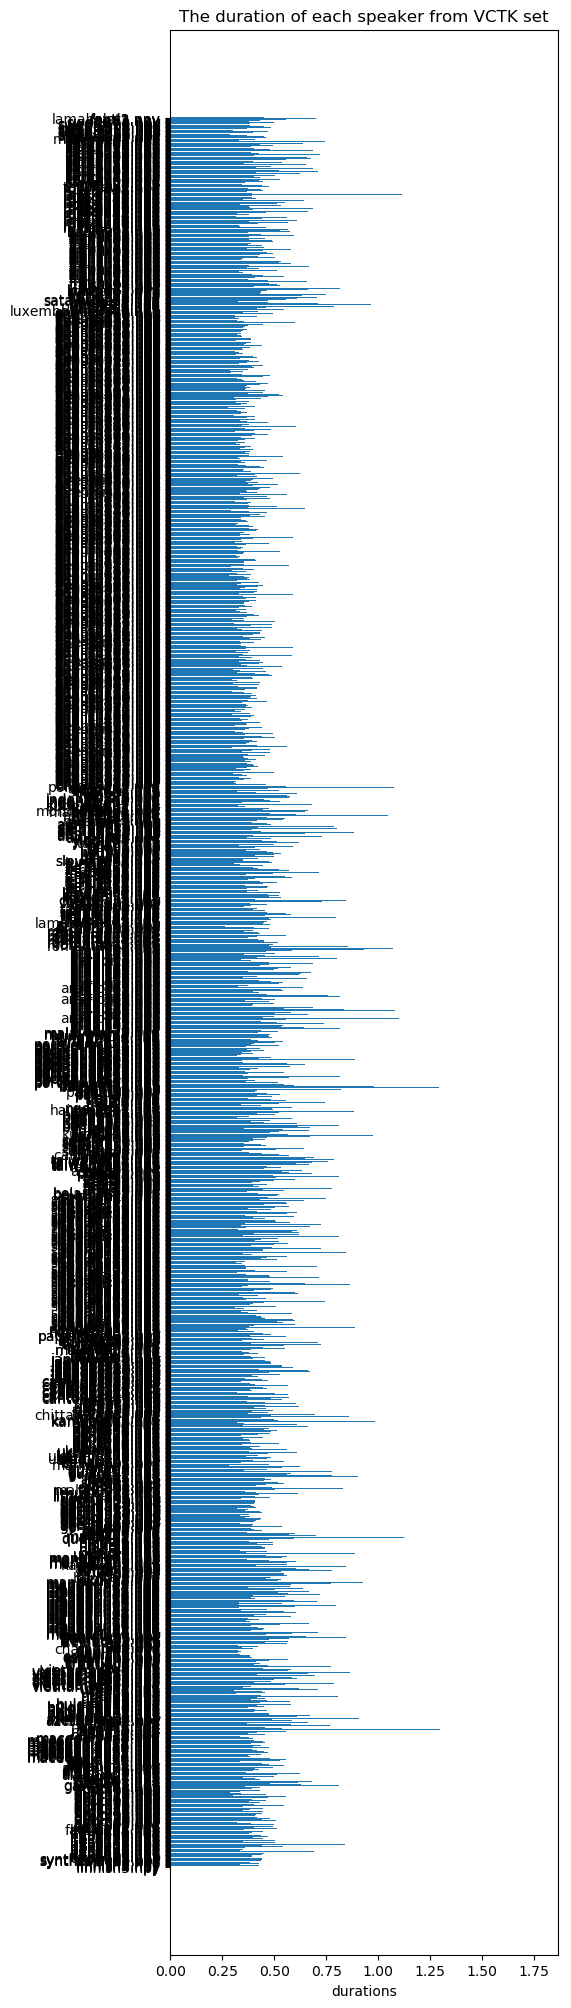

In [16]:
from synthesizer.hparams import hparams
import matplotlib.pyplot as plt
%matplotlib inline

spk2utts = {}
with open('datasets/syn_accent/synthesizer/train.txt') as metadata_file:
    for line in metadata_file:
        items = line.strip().split("|")
        spk = items[0].replace('audio-', '').split('_')[0]
        if spk not in spk2utts.keys():
            spk2utts[spk] = []
        spk2utts[spk].append(int(items[3]))

spks = list(spk2utts.keys())
len_in_min = [sum(spk2utts[i]) / hparams.sample_rate / 60 for i in spks]
print('%d speakers are used for training and testing' % len(spks))
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(5, 25))

y_pos = np.arange(len(spks))


ax.barh(y_pos, len_in_min, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(spks)
ax.invert_yaxis() 
ax.set_xlabel('durations')
ax.set_title('The duration of each speaker from VCTK set')

plt.show()


# split the data into training testing and validation set

In [9]:
! mv datasets/vctk/synthesizer/train.txt datasets/vctk/synthesizer/all.txt

In [10]:
utts = [line.strip() for line in open('datasets/vctk/synthesizer/all.txt', 'r').readlines()]
spk_dict = {}

for u in utts:
    spk = u.split('-')[1].split('_')[0]
    assert spk[0] == 'p'
    if spk not in spk_dict.keys():
        spk_dict[spk] = []
    spk_dict[spk].append(u)

spk2num = [(spk, len(spk_dict[spk])) for spk in spk_dict.keys()]
spk2num.sort(key=lambda x:x[1])
test_set = spk2num[:8]
training_set = spk2num[8:]

train_wf = open('datasets/vctk/synthesizer/train.txt', 'w')
test_wf = open('datasets/vctk/synthesizer/test.txt', 'w')
val_wf = open('datasets/vctk/synthesizer/val.txt', 'w')

for spk, _ in training_set:
    for utt in spk_dict[spk][:8]:
        val_wf.write(utt + '\n')
    for utt in spk_dict[spk][8:]:
        train_wf.write(utt + '\n')
        
for spk, _ in test_set:
    for utt in spk_dict[spk]:
        test_wf.write(utt + '\n')
        
train_wf.close()
test_wf.close()
val_wf.close()

# Next step, speaker embedding extraction, use deep_speaker/get_gvector.ipynb to obtain speaker embedding

In [14]:
x = [['banana','banana1','afujnfaaf'],['resnja','faeočikjf3','sefdfsdf']]
[print(y[0]) for y in x]

banana
resnja


[None, None]